# Sentiment analysis with RNN

In [1]:
import numpy as np
import scipy.sparse
import json
import zipfile

import spacy
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.matutils import corpus2csc
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from collections import Counter, OrderedDict
from os.path import expanduser
import re, time
from sklearn.model_selection import train_test_split

import torch
import torch.nn.utils.rnn as rnn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from itertools import zip_longest
from operator import itemgetter

import zipfile
import pandas as pd
import jsonlines as jsonl

from dataclasses import dataclass

In [3]:
re_run = True
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

# Importing

In [89]:
def load_embeddings(emb_path: str) -> dict:
    """load glove vectors"""
    
    embeddings_index={}
    
    with zipfile.ZipFile(expanduser("~")+ emb_path +'glove.6B.zip', 'r') as f:
        with f.open('glove.6B.100d.txt', 'r') as z:
            for line in z:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float16')
                embeddings_index[word] = coefs
    
    return embeddings_index

def id_to_glove(dict_yelp: corpora.Dictionary, emb_path: str):
    
    """converts local dictionary to embeddings from glove"""
    
    embeddings_index = load_embeddings(emb_path)
    conversion_table = {}
    
    for word in dict_yelp.values():
        if bytes(word, 'utf-8') in embeddings_index.keys():
            conversion_table[dict_yelp.token2id[word]+1] = embeddings_index[bytes(word, 'utf-8')]
        else:
            conversion_table[dict_yelp.token2id[word]+1] = np.random.normal(0, .32, 100)
            
    embedding_matrix = np.vstack(
        (
            np.zeros(100), 
            list(conversion_table.values()), 
            np.random.randn(100)
        )
    )
    
    return embedding_matrix

def convert_rating(rating):
    
    """moving ratings from 0 to 1"""
    
    if rating in [4,5]:
        return 1
    elif rating in [1,2]:
        return 0

def load_data(path: str, fname: str, stop: int = None) -> list:

    "reads from zipped yelp data file"
    
    ls = []
    with zipfile.ZipFile(path) as zfile:
        print(zfile.namelist())
        inf = zfile.open(fname)
        with jsonl.Reader(inf) as file:
            for i, line in enumerate(file):
                line['text'] = tokenize(line.get('text'))
                ls.append(line)
                if stop and i == stop:
                    break
    return ls


def text_sequencer(dictionary, text, max_len=200):
    
    """converts tokens to numeric representation by dictionary"""
    
    processed = np.zeros(200, dtype=int)
    # in case the word is not in the dictionary because it was filtered out use this number to represent an out of set id 
    dict_final = len(dictionary.keys()) + 1
    
    for i, word in enumerate(text):        
        if i >= max_len:
            return processed
        if word in dictionary.token2id.keys():
            # the ids have an offset of 1 for this because 0 represents a padded value        
            processed[i] = dictionary.token2id[word] + 1
        else:
            processed[i] = dict_final
    
    return processed

# regex tokenize, less accurate
def tokenize(x): return re.findall('\w+', x.lower())

def load_data(path: str, fname: str, stop: int = None) -> list:
    "reads from zipped yelp data file"
    ls = []
    with zipfile.ZipFile(path) as zfile:
        print(zfile.namelist())
        inf = zfile.open(fname)
        with jsonl.Reader(inf) as file:
            for i, line in enumerate(file):
                line['text'] = tokenize(line.get('text'))
                ls.append(line)
                if stop and i == stop-1:
                    break
    return ls




class CorpusData(Dataset):
    
    """Dataset class required for pytorch to output items by index"""
    
    test_size = 0.25
    def __init__(
        self, 
        fpath: str, 
        fname: str, 
        stop: int = None, 
        data: str = 'data',
        labels: str = 'target', 
        test_size=0.25
    ):
        
        super().__init__()
        self.fpath: str
        self.fname: str
        self.stop: int = None
        self.data = data
        self.labels = labels
        self.dict_yelp: corpora.Dictionary = None
        self.df: pd.DataFrame = self.parse_data(fpath, fname, stop)
        self.test_size: float = test_size
        self.tr_idx: list = None
        self.val_idx: list = None
        self.split_df()
        
    def parse_data(self, fpath, fname, stop):
        
        df = pd.DataFrame(load_data(fpath, fname, stop))
        print('df loaded..')
        self.dict_yelp = corpora.Dictionary(df.text)
        self.dict_yelp.filter_extremes(no_below=10, no_above=.95, keep_n=30000)
        print('dictionary created...')
        df[self.data] = df.text.apply(lambda x: text_sequencer(self.dict_yelp, x))
        df[self.labels] = df.stars.apply(convert_rating)
        
        return df.loc[df[self.labels].dropna()].reset_index(drop=True)
        
    def __len__(self):
        return self.df.__len__()
    
    def __getitem__(self, i):
        
        return self.df[self.data][i], self.df[self.labels][i]
            
    def split_df(self):
        
        self.tr_idx, self.val_idx = train_test_split(self.df.index.values, test_size = self.test_size)
        return self
    
    @property
    def train(self):
        return self.df.iloc[self.tr_idx]
    
    @property
    def val(self):
        return self.df.iloc[self.val_idx]

In [64]:
import gc 
gc.collect()
fpath = '../data/archive.zip'
fname = 'yelp_academic_dataset_review.json'

In [83]:
%%time

dataset = CorpusData(
    fpath=fpath, 
    fname=fname, 
    stop=10000
)

['Dataset_User_Agreement.pdf', 'yelp_academic_dataset_business.json', 'yelp_academic_dataset_checkin.json', 'yelp_academic_dataset_review.json', 'yelp_academic_dataset_tip.json', 'yelp_academic_dataset_user.json']
df loaded..
dictionary created...
CPU times: user 1.95 s, sys: 40.1 ms, total: 1.99 s
Wall time: 1.97 s


## Integrating glove embeddings

In [9]:
%%time
embedding_matrix = id_to_glove(dataset.dict_yelp, '/projects/yelp_nlp/data/')


CPU times: user 11.5 s, sys: 107 ms, total: 11.6 s
Wall time: 11.6 s


## Labels

## Modeling 

In [10]:
def sort_array(all_lens): 
    return np.unique(all_lens), np.bincount(all_lens), len(np.unique(all_lens)), len(np.bincount(all_lens))

def resort_lens(idx, lens):
    resorted_lenidx = np.array(sorted(zip(idx, lens), key=itemgetter(1), reverse=True))
    return resorted_lenidx

def resample_data(data, label, idx, lens):
    
        if isinstance(data, np.ndarray):
            pass
        else:
            data= np.array(data)
        assert len(data) == len(label)
        sorted_ = resort_lens(idx, lens)
        return data[sorted_[:,0]], label[sorted_[:,0]], sorted_[:,1]
    
#trainiter = iter(train_loader)

def sort_lens(x, y, lens):
    x=torch.stack(x,dim=1)
    lens_, indices = lens.sort(descending=True)
    x_, y_ = x[indices], y[indices]
    return x_, y_, lens_

def split(sorted_data, sorted_lab, all_lens, random_state=5):
    
    tr_idx, val_idx, tr_lens, val_lens = train_test_split(range(len(all_lens)), all_lens, \
                     test_size = 0.2, stratify=all_lens,\
                     random_state=random_state)
    
    train, train_y, tr_lens_ = resample_data(sorted_data, sorted_lab, tr_idx, tr_lens)
    val, val_y, val_lens_ = resample_data(sorted_data, sorted_lab, val_idx, val_lens)
    return {'train':[tr_idx, train, train_y, tr_lens_], 'val':[val_idx, val, val_y, val_lens_]}

In [11]:
def get_batches(x, y, bsize):
    
    count = int(len(y)/bsize)+1
    def convert(lsls):
        return torch.stack([torch.tensor(ls) for ls in lsls])
    for i in range(count):
        a,b,c = len(y[i*bsize:(i+1)*bsize]), x[i*bsize:(i+1)*bsize], y[i*bsize:(i+1)*bsize]
        yield a, convert(b), torch.tensor(c) 
        


In [12]:
class RNN(nn.Module):
    
    # weights are vocabsize x embedding length
    def __init__(self, emb_weights, batch_size, input_len):
    
        super().__init__()
        # vocab size in, hidden size out
        self.batch_size = batch_size
        self.embed_layer = nn.Embedding(emb_weights.shape[0], emb_weights.shape[1])
        self.emb_weights = emb_weights
        # input of shape (seq_len, batch, input_size) https://pytorch.org/docs/stable/nn.html
        self.lstm = nn.LSTM(input_len, input_len)
        
        """Input: (N, *, \text{in\_features})(N,∗,in_features) where *∗ means any number of additional dimensions
        Output: (N, *, \text{out\_features})(N,∗,out_features) where all but the last dimension are the same shape as the input."""
        
        self.fc1 = nn.Linear(input_len,1)
        self.fc2 = nn.Linear(emb_weights.shape[1], 1)
        

    def load_weights(self):
        self.embed_layer.load_state_dict({'weight': self.emb_weights})
        return self
    
    def forward(self, inputs, p=0.2, verbose=False):
        
        
        embeds = self.embed_layer(inputs)
        
        nn.Dropout2d(p=p, inplace=True)(embeds)
        
        if verbose:
            print('embedding shape %s' % (embeds.shape,))
        
        out, (hidden, cell) = self.lstm(embeds.permute(0,2,1))
        
        if verbose:
            print('lstm out shape %s' % (out.shape,))
        
        out = F.relu(self.fc1(out))
        if verbose:
            print('fc1 out shape %s' % (out.shape,))
        
        fout = self.fc2(out.view(1,-1,100))
        if verbose:
            print('final %s' % (fout.shape,))
        #prob = torch.sigmoid(fout)
        
        return fout.view(-1) 
    
class RNNpacked(nn.Module):
    
    def __init__(self, emb_weights, batch_size, input_len):
 
        super().__init__()
        
        # vocab size in, hidden size out
        self.batch_size = batch_size
        self.embed_layer = nn.Embedding(emb_weights.shape[0], emb_weights.shape[1])
        self.emb_weights = emb_weights
        self.dropout1 = nn.Dropout(p=0.5, inplace=True) 
        self.dropout3d1 = nn.Dropout3d(p=0.5, inplace=True)
        self.dropout3d2 = nn.Dropout3d(p=0.5, inplace=True)
        
        # input of shape (seq_len, batch, input_size) https://pytorch.org/docs/stable/nn.html
        self.lstm = nn.LSTM(emb_weights.shape[1], emb_weights.shape[1])
        self.dropout2d1 = nn.Dropout2d(p=0.5, inplace=True)
        self.dropout2d2 = nn.Dropout2d(p=0.5, inplace=True)
        
        """Input: (N, *, \text{in\_features})(N,∗,in_features) where *∗ means any number of additional 
        dimensions Output: (N, *, \text{out\_features})(N,∗,out_features) where all but the last dimension 
        are the same shape as the input."""
        
        self.fc1 = nn.Linear(emb_weights.shape[1], 1)
        self.fc2 = nn.Linear(input_len,1)
        
    def load_weights(self):
        self.embed_layer.load_state_dict({'weight': self.emb_weights})
        return self
    
    def forward(self, inputs, input_lengths=None, verbose=False):
        if verbose:
            print('inputs', inputs.shape)
            
        #self.dropout1(inputs)
        embeds = self.embed_layer(inputs)
        if verbose:
            print('embeds', embeds.shape)
            print(embeds)
        
        #self.dropout3d1(embeds)
        self.dropout2d1(embeds)
        
        if verbose:    
            print(embeds)
        packed = rnn.pack_padded_sequence(embeds, input_lengths, batch_first=True)
        
        if verbose:
            print('packed', packed[0].shape)
        out, (hidden, cell) = self.lstm(packed)
        unpacked, lengths = rnn.pad_packed_sequence(out, total_length=200, batch_first=True)
        
        if verbose:
            print('unpacked', unpacked.shape)
        out = self.fc1(unpacked)
        if verbose:
            print('out', out.shape)
        
        self.dropout2d2(out)
        #self.dropout3d2(out)
        
        fout = self.fc2(out.permute(0,2,1))
        if verbose:
            print('fout', fout.shape)
        prob = F.sigmoid(fout)
        
        return fout.view(-1)


In [22]:
# see https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cuda'
batch_size = 200
input_len = 200
emb_t = torch.from_numpy(embedding_matrix)
emb = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
emb.load_state_dict({'weight': emb_t})
model = RNN(emb_weights=emb_t, batch_size=batch_size, input_len=input_len)
model.load_weights()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.7, 0.99), weight_decay=1e-5)
loss_function = nn.BCEWithLogitsLoss()
# model_packed = RNNpacked(emb_weights=emb_t, batch_size=batch_size, input_len=input_len)
# model_packed.load_weights()
# model_packed.to(device)
# optimizer = optim.Adam(model_packed.parameters(), lr=0.001)
#torch.nn.utils.clip_grad_norm(mdl_sgd.parameters(),clip)

def fit(model, loss_function, opitmizer, dataclass, batch_size, epochs, device, packed=False):
    
    start = time.time()
    model.train()
    
    epoch_count = 0
    losses = []
    train_loader = DataLoader(dataclass, batch_size=batch_size)

    def train_epoch():
        
        nonlocal dataclass, train_loader, losses
        
        i=0
        n=len(dataclass)
        
        for j, (sent, target) in enumerate(train_loader):
            
            optimizer.zero_grad()
            
           
            sent, labels = sent.long().to(device), target.float().to(device)
            log_probs = model(sent)
            #print(log_probs, labels)
            loss = loss_function(log_probs, labels.to(device))
            
            # gets graident
            loss.backward()
            
            # clips high gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.3, norm_type=2)
            
            # updates with new gradient
            optimizer.step()
            
            i += len(labels)
            #print(loss)
            losses.append(loss.item())
            if i % (batch_size*100) == 0:
                print(f"""{i/n:.2f} of rows completed in {j+1} cycles, current loss at {np.mean(losses[-30:]):.4f}""" )

    
    print('fitting model...')

    for epoch in range(epochs):
    
        train_epoch()
        
        epoch_count += 1
        print(f'epoch {epoch_count} complete')
    print(f'fit complete {time.time()-start:.0f} seconds passed')
    return losses


In [23]:
%%time
# import pdb; pdb.set_trace()
losses = fit(model, loss_function, optimizer, 
                    dataset, batch_size, 1, device=device, 
                    packed=False)

fitting model...
0.23 of rows completed in 100 cycles, current loss at 0.0106
0.45 of rows completed in 200 cycles, current loss at 0.0057
0.68 of rows completed in 300 cycles, current loss at 0.0034
0.91 of rows completed in 400 cycles, current loss at 0.0020
epoch 1 complete
fit complete 10 seconds passed
CPU times: user 9.58 s, sys: 19.1 ms, total: 9.6 s
Wall time: 9.61 s


In [19]:
for item in optimizer.param_groups:
    print(item['lr'])

0.0001


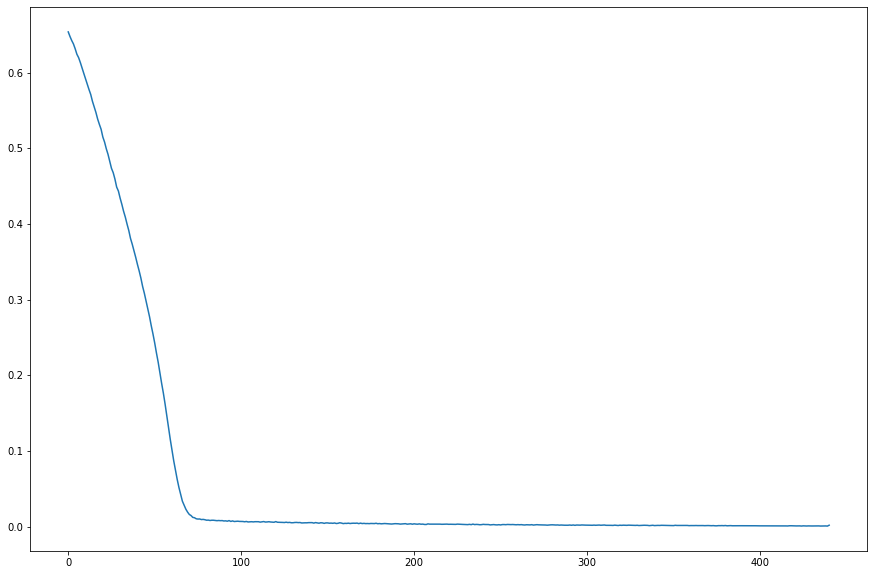

In [15]:
plt.figure(figsize = (15,10))
_ = plt.plot(losses)
# plt.xlim(0, 500)
# plt.ylim(0,.7)

In [16]:
valcls = CorpusData(data=val, labels=val_y)
#val_loader = DataLoader(valcls, batch_size=250)

def eval_model(model, valcls, loss_function, batch_size):
    
    val_loader = DataLoader(valcls, batch_size=batch_size)
    preds = []; targets = []
    with torch.no_grad():

        model.eval()
        for sent, target in val_loader:
            #seqs, labels, lens_ = sort_lens(sent, target, lens)
            #seqs = seqs.long().to(device)

            res = model(sent.cuda())
            
            preds.append(res), targets.append(target)
    
    res = torch.cat(preds).cpu()
    tru = torch.cat(targets).cpu()
    
    print(loss_function(res, tru.float()))    
    

    return res, tru

preds, tru = eval_model(model, valcls, loss_function, 500)

NameError: name 'val' is not defined

In [17]:
def classify(true, preds, cutoff):
    #preds = 1/(1+np.exp(-preds))
    
    res = np.greater(preds, np.array(cutoff))
    recall = np.sum(res*true) / np.sum(true)
    precision = np.sum(res*true) / np.sum(res)
    return {'accuracy':round(np.mean(np.equal(true, res)), 4), 'precision': round(precision,4),\
            'recall': round(recall, 4), 'combined':round(precision*recall,4)}

def get_reviewtext(row): 
    return ' '.join([dict_yelp[item-1] for item in traincls[row][0] if (item < 12589) and (item != 0)])

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [18]:
def evaluate(val, val_y, regression = False):
    
        
    preds = model.predict(val)
    #idx = np.random.randint(0, len(val_y), 5000)
    pred_err = np.subtract(val_y.astype('float32'), preds.reshape(-1))
    sns.distplot(pred_err)
    plt.show()
   
    if regression:
        rmse = np.sqrt(np.mean(pred_err**2))
        print('rmse : %.4f' % rmse)
    else:
        cond_error = round((abs(pred_err) >= 0.5).sum()/len(pred_err), 4)
        binary_cross_entropy = np.mean(
                                        val_y * np.log(preds.reshape(-1)) + \
                                       (1-val_y) * np.log(1-preds.reshape(-1))
        ) 
    
        print('prob error is greater than 0.5 is %.4f' % cond_error)
        print('binary cross entropy is %.4f' % binary_cross_entropy)
    